In [178]:
#GETTING DATA
import nltk
import json
from random import shuffle
from nltk.corpus import twitter_samples
#nltk.download("twitter_samples")
#nltk.download("stopwords")
#nltk.download("punkt")
#nltk.download("wordnet")

positive = twitter_samples.strings("positive_tweets.json")
negative = twitter_samples.strings("negative_tweets.json")
all_tweets = positive + negative
split = len(positive)//4
all_tweets[:5]

['#FollowFriday @France_Inte @PKuchly57 @Milipol_Paris for being top engaged members in my community this week :)',
 '@Lamb2ja Hey James! How odd :/ Please call our Contact Centre on 02392441234 and we will be able to assist you :) Many thanks!',
 '@DespiteOfficial we had a listen last night :) As You Bleed is an amazing track. When are you in Scotland?!',
 '@97sides CONGRATS :)',
 'yeaaaah yippppy!!!  my accnt verified rqst has succeed got a blue tick mark on my fb profile :) in 15 days']

In [179]:
#FILTERING TWEETS
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
import re

def filter_tweet(tweet):
    stop_words = set(stopwords.words("english")) #storing stop words in set
    lem = WordNetLemmatizer()
    tweet = re.sub(r'@[A-Za-z0-9_-]+', '', str(tweet)) #removing @'s'
    tweet = re.sub(r'&amp;*', '', tweet) #removing &amp
    tweet = re.sub(r'https?:\/\/\S+', '', tweet) #removing hyperlinks
    tweet = re.sub(r'#', '', tweet)
    tweet = re.sub(r'\s{2,}', ' ', tweet) #removing extra spaces
    tweet_token = word_tokenize(tweet) #tokenizing string by words
    tweet = [lem.lemmatize(w.lower()) for w in tweet_token if w.lower() not in stop_words] #removing stop words and getting base form of word
    return tweet

In [180]:
pos_filtered = list(map(filter_tweet, positive))
neg_filtered = list(map(filter_tweet, negative))

In [181]:
pos_filtered[:2]

[['followfriday', 'top', 'engaged', 'member', 'community', 'week', ':', ')'],
 ['hey',
  'james',
  '!',
  'odd',
  ':',
  '/',
  'please',
  'call',
  'contact',
  'centre',
  '02392441234',
  'able',
  'assist',
  ':',
  ')',
  'many',
  'thanks',
  '!']]

In [182]:
#LOOKING AT FREQ DISTR FOR MOST COMMON WORDS
fdpos_char = nltk.FreqDist(w for tweet in pos_filtered for w in tweet if w.isalpha())
fdpos_all = nltk.FreqDist(w for tweet in pos_filtered for w in tweet)
fdneg_char = nltk.FreqDist(w for tweet in neg_filtered for w in tweet if w.isalpha())
fdneg_all = nltk.FreqDist(w for tweet in neg_filtered for w in tweet)
#fd_char.tabulate(100)
print("[POS] Most common (alpha values):\n", fdpos_char.most_common(5))
print("[POS] Most common (all values):\n", fdpos_all.most_common(5))
print("[NEG] Most common (alpha values):\n", fdneg_char.most_common(5))
print("[NEG] Most common (all values):\n", fdneg_all.most_common(5))


[POS] Most common (alpha values):
 [('thanks', 393), ('u', 361), ('love', 325), ('follow', 307), ('thank', 246)]
[POS] Most common (all values):
 [(':', 5475), (')', 5160), ('!', 1920), ('.', 1229), (',', 963)]
[NEG] Most common (alpha values):
 [('please', 274), ('miss', 243), ('u', 234), ('want', 226), ('like', 211)]
[NEG] Most common (all values):
 [('(', 7075), (':', 5397), ('.', 1028), ('!', 895), (',', 733)]


In [183]:
#LOOKING AT MOST COMMON COMBINATIONS
from nltk.collocations import BigramCollocationFinder
from nltk.collocations import TrigramCollocationFinder

finder_bi = BigramCollocationFinder.from_words(w for tweet in pos_filtered for w in tweet)
finder_bichar = BigramCollocationFinder.from_words(w for tweet in pos_filtered for w in tweet if w.isalpha()) #filtering out symbols & punctuation
finder_tri = TrigramCollocationFinder.from_words(w for tweet in pos_filtered for w in tweet) #filtering out symbols & punctuation
finder_bi.ngram_fd.tabulate(5) #finding most common pair of two-word combinations
finder_tri.ngram_fd.tabulate(5) #finding most common pair of three-word combinations
pair_symb = finder_bi.ngram_fd.most_common(5)
trio_symb = finder_tri.ngram_fd.most_common(5)

(':', ')') (':', '-') ('-', ')') ('!', ':') (')', ')') 
      3743        710        708        616        605 
(':', '-', ')') ('!', ':', ')') (')', ')', ')') ('.', ':', ')') (':', ')', ')') 
            701             397             326             258             232 


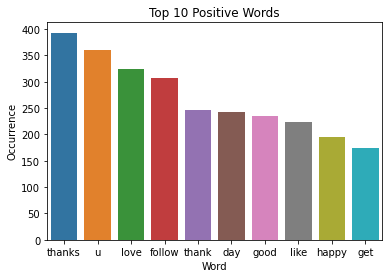

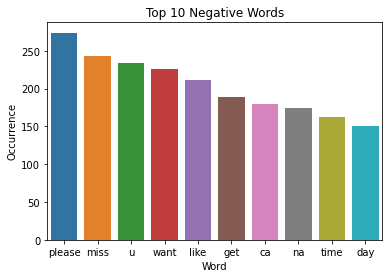

In [184]:
#VISUALIZING MOST COMMON WORDS
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pos_words = pd.DataFrame(fdpos_char.most_common(10), columns=["Word", "Occurrence"])
sns.barplot(x="Word", y="Occurrence", data=pos_words)
plt.title(label="Top 10 Positive Words")
plt.show()

neg_words = pd.DataFrame(fdneg_char.most_common(10), columns=["Word", "Occurrence"])
sns.barplot(x="Word", y="Occurrence", data=neg_words)
plt.title(label="Top 10 Negative Words")
plt.show()

In [185]:
#EXTRACTING FEATURES FROM TWEET
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize
import pandas as pd

lem = WordNetLemmatizer()
top_100_pos = [lem.lemmatize(word[0]) for word in fdpos_char.most_common(100)]
top_100_neg = [lem.lemmatize(word[0]) for word in fdneg_char.most_common(100)]
def extract_features(tweet_list, sent): #returns dataframe with features from each tweet in tweet_list
    sia = SentimentIntensityAnalyzer()
    ucase_count = 0
    at_count = 0
    results_df = pd.DataFrame(columns=
                              ["tweet", 
                               "pos_words", 
                               "neg_words", 
                               "ucase_count", 
                               "at_count",
                               "word_count", 
                               "punctuation_count", 
                               "sia_compound", 
                               "sentiment"])
    for tweet in tweet_list:
        pos = neg = 0
        ucase_count = len(re.findall(r'[A-Z]{2,}', tweet))
        at_count = len(re.findall(r'@+', tweet))
        filtered_tweet = filter_tweet(tweet) #filtering tweet
        punct_count = len([w for w in filtered_tweet if not w.isalpha()]) #getting punctuation count
        word_count = len(filtered_tweet) - punct_count #getting word count
        pos += len(re.findall(r':-?\)+', tweet)) #counting occurences of pos symbols
        neg += len(re.findall(r':-?\(+', tweet)) #counting occurence of neg symbols
        for word in filtered_tweet:
            if word in top_100_pos: 
                pos += 1 #counting occurrences of pos words
            if word in top_100_neg: 
                neg += 1 #counting occurrences of neg words
        results_df = results_df.append({
            "tweet": tweet, 
            "pos_words": pos, 
            "neg_words": neg, 
            "ucase_count": ucase_count,
            "at_count": at_count,
            "word_count": word_count, #word count of filtered tweet
            "punctuation_count": punct_count, #punct count of filtered tweet
            "sia_compound": sia.polarity_scores(tweet)["compound"], #getting compound polarity score (range from -1 to 1, 1 being more pos, -1 being more negative)
            "sentiment": 0 if sent == "pos" else 1},
            ignore_index=True)
    return results_df

In [186]:
#COMBINING POS AND NEG DF INTO SINGLE A DF
pos_df = extract_features(positive, "pos")
neg_df = extract_features(negative, "neg")
all_df = pd.concat([pos_df, neg_df], axis=0, join="outer")

In [187]:
all_df.head()

,tweet,pos_words,neg_words,ucase_count,at_count,word_count,punctuation_count,sia_compound,sentiment
0,#FollowFriday @France_Inte @PKuchly57 @Milipol...,2,1,1,3,6,2,0.7579,0
1,@Lamb2ja Hey James! How odd :/ Please call our...,4,2,0,1,11,7,0.6229,0
2,@DespiteOfficial we had a listen last night :)...,4,2,0,1,7,5,0.7959,0
3,@97sides CONGRATS :),1,0,1,1,1,2,0.7983,0
4,yeaaaah yippppy!!! my accnt verified rqst has...,3,2,0,0,13,6,0.7950,0


In [188]:
all_df.info() #looking for null values (shouldn't be any since data is preprocessed)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 4999
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   tweet              10000 non-null  object 
 1   pos_words          10000 non-null  object 
 2   neg_words          10000 non-null  object 
 3   ucase_count        10000 non-null  object 
 4   at_count           10000 non-null  object 
 5   word_count         10000 non-null  object 
 6   punctuation_count  10000 non-null  object 
 7   sia_compound       10000 non-null  float64
 8   sentiment          10000 non-null  object 
dtypes: float64(1), object(8)
memory usage: 781.2+ KB


In [189]:
#SPECIFYING APPROPRIATE DATA TYPE FOR EACH COLUMN
convert = {"tweet": object,
          "pos_words": int,
          "neg_words": int,
          "ucase_count": int,
          "at_count": int,
          "word_count": int,
          "punctuation_count": int,
          "sia_compound": float,
          "sentiment": int}
all_df = all_df.astype(convert)
all_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 4999
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   tweet              10000 non-null  object 
 1   pos_words          10000 non-null  int32  
 2   neg_words          10000 non-null  int32  
 3   ucase_count        10000 non-null  int32  
 4   at_count           10000 non-null  int32  
 5   word_count         10000 non-null  int32  
 6   punctuation_count  10000 non-null  int32  
 7   sia_compound       10000 non-null  float64
 8   sentiment          10000 non-null  int32  
dtypes: float64(1), int32(7), object(1)
memory usage: 507.8+ KB


In [190]:
all_df.duplicated().sum()

0

In [191]:
from sklearn.model_selection import train_test_split
#axis 0 = row: direction you want to move is down ACROSS rows
#axis 1 = col: direction you want to move is ACROSS the column axis
X = all_df.drop(["tweet", "sentiment", "sia_compound"], axis=1, inplace=False) 
y = all_df.sentiment

#splitting data into train/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

In [158]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(6700, 6)
(3300, 6)
(6700,)
(3300,)


Best estimator N: 18
Best score: 0.93


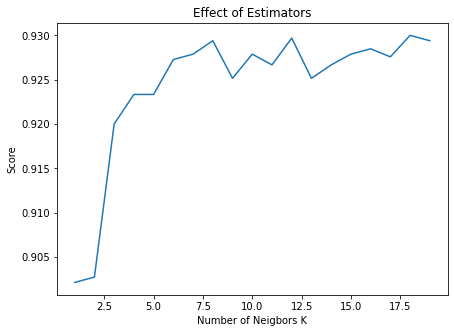

In [166]:
import numpy as np
from numpy import mean, std
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn import metrics

scores = []
range_ = np.arange(1, 20, 1)
best_n = 0
best_score = 0
for i in range_:
    knn = KNeighborsClassifier(n_neighbors=i, metric="euclidean") #creating KNN model object
    knn.fit(X_train, y_train)
    predicted = knn.predict(X_test)
    score = metrics.accuracy_score(y_test, predicted)
    if best_score < score and score < 1: #saving best score
        best_score = score
        best_n = i #saving best n estimator
    scores.append(score)
plt.figure(figsize=(7, 5))
plt.title("Effect of Estimators")
plt.xlabel("Number of Neigbors K")
plt.ylabel("Score")
plt.plot(range_, scores)

print("Best estimator N: {}".format(best_n))
print("Best score: {}".format(best_score))

In [168]:
#USING CROSS VALIDATION ON MODEL WITH BEST N
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

knn = KNeighborsClassifier(n_neighbors=best_n, metric="euclidean") #creating KNN model object
score = cross_val_score(knn, X, y, cv=10)
pred = cross_val_predict(knn, X, y, cv=10)

score.mean()

0.9299

##### Recall: from all the positive classes (TP), how many we predicted correctly. Should be as high as possible
##### Precision: from all the classes we have predicted as positive (TP), how many are actually positive. Should be as high as possible
##### Accuracy: from all the classes (pos & neg), how many of them we have predicted correctly. Should be as high as possible
##### F-score: helps measure recall and precision at the same time

In [175]:
print(metrics.classification_report(y, pred))

              precision    recall  f1-score   support

           0       0.93      0.93      0.93      5000
           1       0.93      0.93      0.93      5000

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000



In [162]:
from sklearn import svm
clf = svm.SVC()
clf.fit(X_train, y_train)
score = cross_val_score(knn, X, y, cv=5)
pred = cross_val_predict(knn, X, y, cv=5)

score.mean()

0.9299

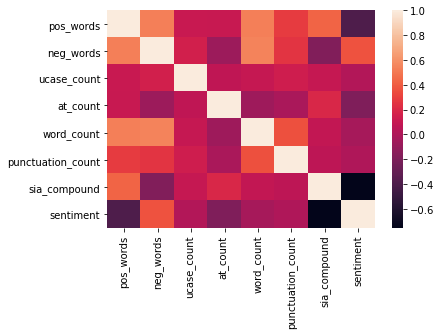

In [164]:
#LOOKING AT BEST FEATURES
import seaborn as sns
sns.heatmap(all_df.corr())

In [165]:
all_df.corr()

,pos_words,neg_words,ucase_count,at_count,word_count,punctuation_count,sia_compound,sentiment
pos_words,1.000000,0.533342,0.113907,0.103658,0.529278,0.281735,0.428149,-0.390369
neg_words,0.533342,1.000000,0.156637,-0.070646,0.544162,0.254798,-0.177634,0.368604
ucase_count,0.113907,0.156637,1.000000,0.074995,0.102111,0.143636,0.099277,0.015092
at_count,0.103658,-0.070646,0.074995,1.000000,-0.064843,-0.016096,0.193121,-0.187681
word_count,0.529278,0.544162,0.102111,-0.064843,1.000000,0.359036,0.084478,-0.031826
punctuation_count,0.281735,0.254798,0.143636,-0.016096,0.359036,1.000000,0.062830,0.007299
sia_compound,0.428149,-0.177634,0.099277,0.193121,0.084478,0.062830,1.000000,-0.752335
sentiment,-0.390369,0.368604,0.015092,-0.187681,-0.031826,0.007299,-0.752335,1.000000
